# NBA Hackathon 2019 - Business Question 

## The Question
We have provided a sample dataset of 1,000 (real) Instagram posts by @nba since 
October 1, 2017 (211 individual photos, 109 photo albums, and 680 videos) for 
which your task is to predict total “engagements.” Note that these “engagements” 
are *not* real – i.e., we’ve artificially generated the Engagements column such 
that there’s no (intentional) correlation with the real-life engagement totals 
belonging to posts by @nba. 

To assist with your model, we have provided an identical dataset of 7,766 (real) 
Instagram posts. Using these inputs, predict Engagements for each of the 1,000 
posts in the holdout set. You will be graded on Mean Absolute Percentage Error 
(MAPE) on Total Viewers. We selected this metric due to scaling in the 
“engagements” response variable. Further details on each source file and on the 
MAPE evaluation metric are provided in the prompt PDF made available here. 

Please submit a file named `holdout_set_[Individual_or_Team_Name].csv` 
with the Engagements column filled in with your response variable. Please note 
that each question is permitted a maximum of two file attachments. Please save 
your answer in a .csv file and save your code, spreadsheets, and/or other work 
in a zip file.

## Setup

Please execute the cells below before starting, as they import necessary 
libraries and perform necessary setup.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [64]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/akestner/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [65]:
from sklearn.feature_extraction.text import CountVectorizer
# Import data
posts = pd.read_csv('data/training_set.csv', encoding='unicode_escape')
rename_dict = {
  'Engagements': 'engagements', 
  'Followers at Posting': 'followers', 
  'Created': 'created_at', 
  'Type': 'type', 
  'Description': 'text'
}
posts.rename(rename_dict, axis=1, inplace=True) 
posts = posts[posts['text'].notnull()]
# parse datetimes
posts['created_at'] = pd.to_datetime(posts['created_at'])

In [66]:
# encode post types
posts['type'] = posts['type'].astype('category')
# one hot
posts = pd.concat([posts, pd.get_dummies(posts['type'], prefix='type')], axis=1)

# bag of words encoding for text column
count = CountVectorizer(max_features=500, stop_words='english')
bag_of_words = count.fit_transform(posts['text'])
feature_names = count.get_feature_names()
posts_text_bag_of_words = pd.DataFrame(bag_of_words.toarray(), columns=feature_names)
posts = pd.concat([posts, posts_text_bag_of_words], axis=1)

# encode datetimes
posts['year'] = pd.DatetimeIndex(posts['created_at']).year
posts['month'] = pd.DatetimeIndex(posts['created_at']).month
posts['month_sin'] = np.sin((posts['month'] - 1) * (2.0 * np.pi / 12))
posts['month_cos'] = np.cos((posts['month'] - 1) * (2.0 * np.pi / 12))
posts['day'] = pd.DatetimeIndex(posts['created_at']).day
posts['day_sin'] = np.sin((posts['day'] - 1) * (2.0 * np.pi / 31))
posts['day_cos'] = np.cos((posts['day'] - 1) * (2.0 * np.pi / 31))
posts['day_of_week'] = pd.DatetimeIndex(posts['created_at']).dayofweek
posts['day_of_week_sin'] = np.sin((posts['day_of_week'] - 1) * (2.0 * np.pi / 7))
posts['day_of_week_cos'] = np.cos((posts['day_of_week'] - 1) * (2.0 * np.pi / 7))
posts['hour'] = pd.DatetimeIndex(posts['created_at']).hour
posts['hour_sin'] = np.sin(posts['hour'] * (2.0 * np.pi / 24))
posts['hour_cos'] = np.cos(posts['hour'] * (2.0 * np.pi / 24))

# calculated cols
posts['text_length'] = posts['text'].str.len()

posts.dropna(inplace=True)

posts.head(25)

,engagements,followers,created_at,type,text,type_Album,type_Photo,type_Video,000,00pm,...,month_cos,day_sin,day_cos,day_of_week,day_of_week_sin,day_of_week_cos,hour,hour_sin,hour_cos,text_length
0,502093.0,36984682.0,2019-05-21 23:30:51-04:00,Video,The @raptors bench trio of @sergeibaka @norman...,0.0,0.0,1.0,0.0,0.0,...,-0.5,-0.790776,-0.612106,1.0,0.000000,1.00000,23.0,-2.588190e-01,0.965926,95.0
1,603380.0,36984682.0,2019-05-21 22:53:33-04:00,Video,@kyle_lowry7 pulls from deep for the @raptors ...,0.0,0.0,1.0,0.0,0.0,...,-0.5,-0.790776,-0.612106,1.0,0.000000,1.00000,22.0,-5.000000e-01,0.866025,64.0
2,603380.0,36984682.0,2019-05-21 22:19:58-04:00,Video,@k_mid22 with some english on the @bucks dime!,0.0,0.0,1.0,0.0,0.0,...,-0.5,-0.790776,-0.612106,1.0,0.000000,1.00000,22.0,-5.000000e-01,0.866025,46.0
3,725100.0,36984682.0,2019-05-21 22:02:41-04:00,Video,Kawhi punches it home with the left on TNT!,0.0,0.0,1.0,0.0,0.0,...,-0.5,-0.790776,-0.612106,1.0,0.000000,1.00000,22.0,-5.000000e-01,0.866025,43.0
4,661446.0,36984682.0,2019-05-21 20:47:49-04:00,Video,@giannis_an34 goes baseline early to rock the ...,0.0,0.0,1.0,0.0,0.0,...,-0.5,-0.790776,-0.612106,1.0,0.000000,1.00000,20.0,-8.660254e-01,0.500000,57.0
5,322444.0,36955156.0,2019-05-21 14:02:32-04:00,Photo,Congrats to the 2018-19 NBA All-Rookie First T...,0.0,1.0,0.0,0.0,0.0,...,-0.5,-0.790776,-0.612106,1.0,0.000000,1.00000,14.0,-5.000000e-01,-0.866025,104.0
6,722540.0,36955156.0,2019-05-21 12:30:53-04:00,Video,The @warriors locked in for four games to adva...,0.0,0.0,1.0,0.0,0.0,...,-0.5,-0.790776,-0.612106,1.0,0.000000,1.00000,12.0,1.224647e-16,-1.000000,106.0
7,339265.0,36955156.0,2019-05-21 08:59:02-04:00,Photo,Will the @bucks take a commanding 3-1 lead... ...,0.0,1.0,0.0,0.0,0.0,...,-0.5,-0.790776,-0.612106,1.0,0.000000,1.00000,8.0,8.660254e-01,-0.500000,88.0
8,443330.0,36955156.0,2019-05-21 00:48:16-04:00,Photo,TAP to SHOP the @warriors Western Conference C...,0.0,1.0,0.0,0.0,0.0,...,-0.5,-0.790776,-0.612106,1.0,0.000000,1.00000,0.0,0.000000e+00,1.000000,75.0
9,652193.0,36955156.0,2019-05-21 00:38:18-04:00,Video,Hey @stephencurry30... that was the first time...,0.0,0.0,1.0,0.0,0.0,...,-0.5,-0.790776,-0.612106,1.0,0.000000,1.00000,0.0,0.000000e+00,1.000000,121.0


In [ ]:
## Data Exploration 

plt.scatter(posts['type'], posts['engagements'])
plt.title('Post Type vs. Engagements')

In [ ]:
plt.scatter(posts['created_at'], posts['engagements'])
plt.title('Post Date vs. Engagements')

In [ ]:
plt.scatter(posts['day_of_week'], posts['engagements'])
plt.title('Day of Week vs. Engagements')

In [ ]:
plt.scatter(posts['text_length'], posts['engagements'])
plt.title('Post Length vs. Engagements')

In [ ]:
plt.scatter(posts['followers'], posts['engagements'])
plt.title('Follower Count vs. Engagements')

## Split the (labelled) posts data into training and test datasets

In [67]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

numeric_feature_cols = [
  'followers',
  'type_Photo',
  'type_Album',
  'type_Video',
  'year',
  'month_cos',
  'day_cos',
  'day_of_week_cos',
  'hour_cos',
  'text_length'
]
non_feature_cols = [
  'engagements',
  'type',
  'text',
  'created_at',
  'hour',
  'day',
  'day_of_week',
  'month',
  'month_sin',
  'day_sin',
  'day_of_week_sin',
  'hour_sin',
  'year'
]

X = posts.drop(non_feature_cols, axis=1)
# X = posts[numeric_feature_cols]
y = posts['engagements']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=102)
# standardize data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Train our KNN model

In [68]:
from sklearn.neighbors import KNeighborsRegressor

knn_model = KNeighborsRegressor(n_jobs=4)
knn_model.fit(X_train_scaled, y_train)

y_train_predictions = pd.Series(knn_model.predict(X_train_scaled), index=y_train.index)
y_test_predictions = pd.Series(knn_model.predict(X_test_scaled), index=y_test.index)
posts_predictions = pd.DataFrame({
  'Actual Training Engagements': y_train,
  'Predicted Training Engagements': y_train_predictions,
  'Actual Test Engagements': y_test,
  'Predicted Test Engagements': y_test_predictions
})
posts_predictions['Training Engagements Diff'] = posts_predictions['Actual Training Engagements'] - posts_predictions['Predicted Training Engagements']
posts_predictions['Test Engagements Diff'] = posts_predictions['Actual Test Engagements'] - posts_predictions['Predicted Test Engagements']
posts_predictions['Training Percent Diff'] = posts_predictions['Training Engagements Diff'] / posts_predictions['Actual Training Engagements']
posts_predictions['Test Percent Diff'] = posts_predictions['Test Engagements Diff'] / posts_predictions['Actual Test Engagements']

In [69]:
from sklearn.neighbors import KNeighborsRegressor

knn_model = KNeighborsRegressor()
knn_model.fit(X_train_scaled, y_train)

y_train_predictions = pd.Series(knn_model.predict(X_train_scaled), index=y_train.index)
y_test_predictions = pd.Series(knn_model.predict(X_test_scaled), index=y_test.index)
posts_predictions = pd.DataFrame({
  'Actual Training Engagements': y_train,
  'Predicted Training Engagements': y_train_predictions,
  'Actual Test Engagements': y_test,
  'Predicted Test Engagements': y_test_predictions
})
posts_predictions['Training Engagements Diff'] = posts_predictions['Actual Training Engagements'] - posts_predictions['Predicted Training Engagements']
posts_predictions['Test Engagements Diff'] = posts_predictions['Actual Test Engagements'] - posts_predictions['Predicted Test Engagements']
posts_predictions['Training Percent Diff'] = posts_predictions['Training Engagements Diff'] / posts_predictions['Actual Training Engagements']
posts_predictions['Test Percent Diff'] = posts_predictions['Test Engagements Diff'] / posts_predictions['Actual Test Engagements']

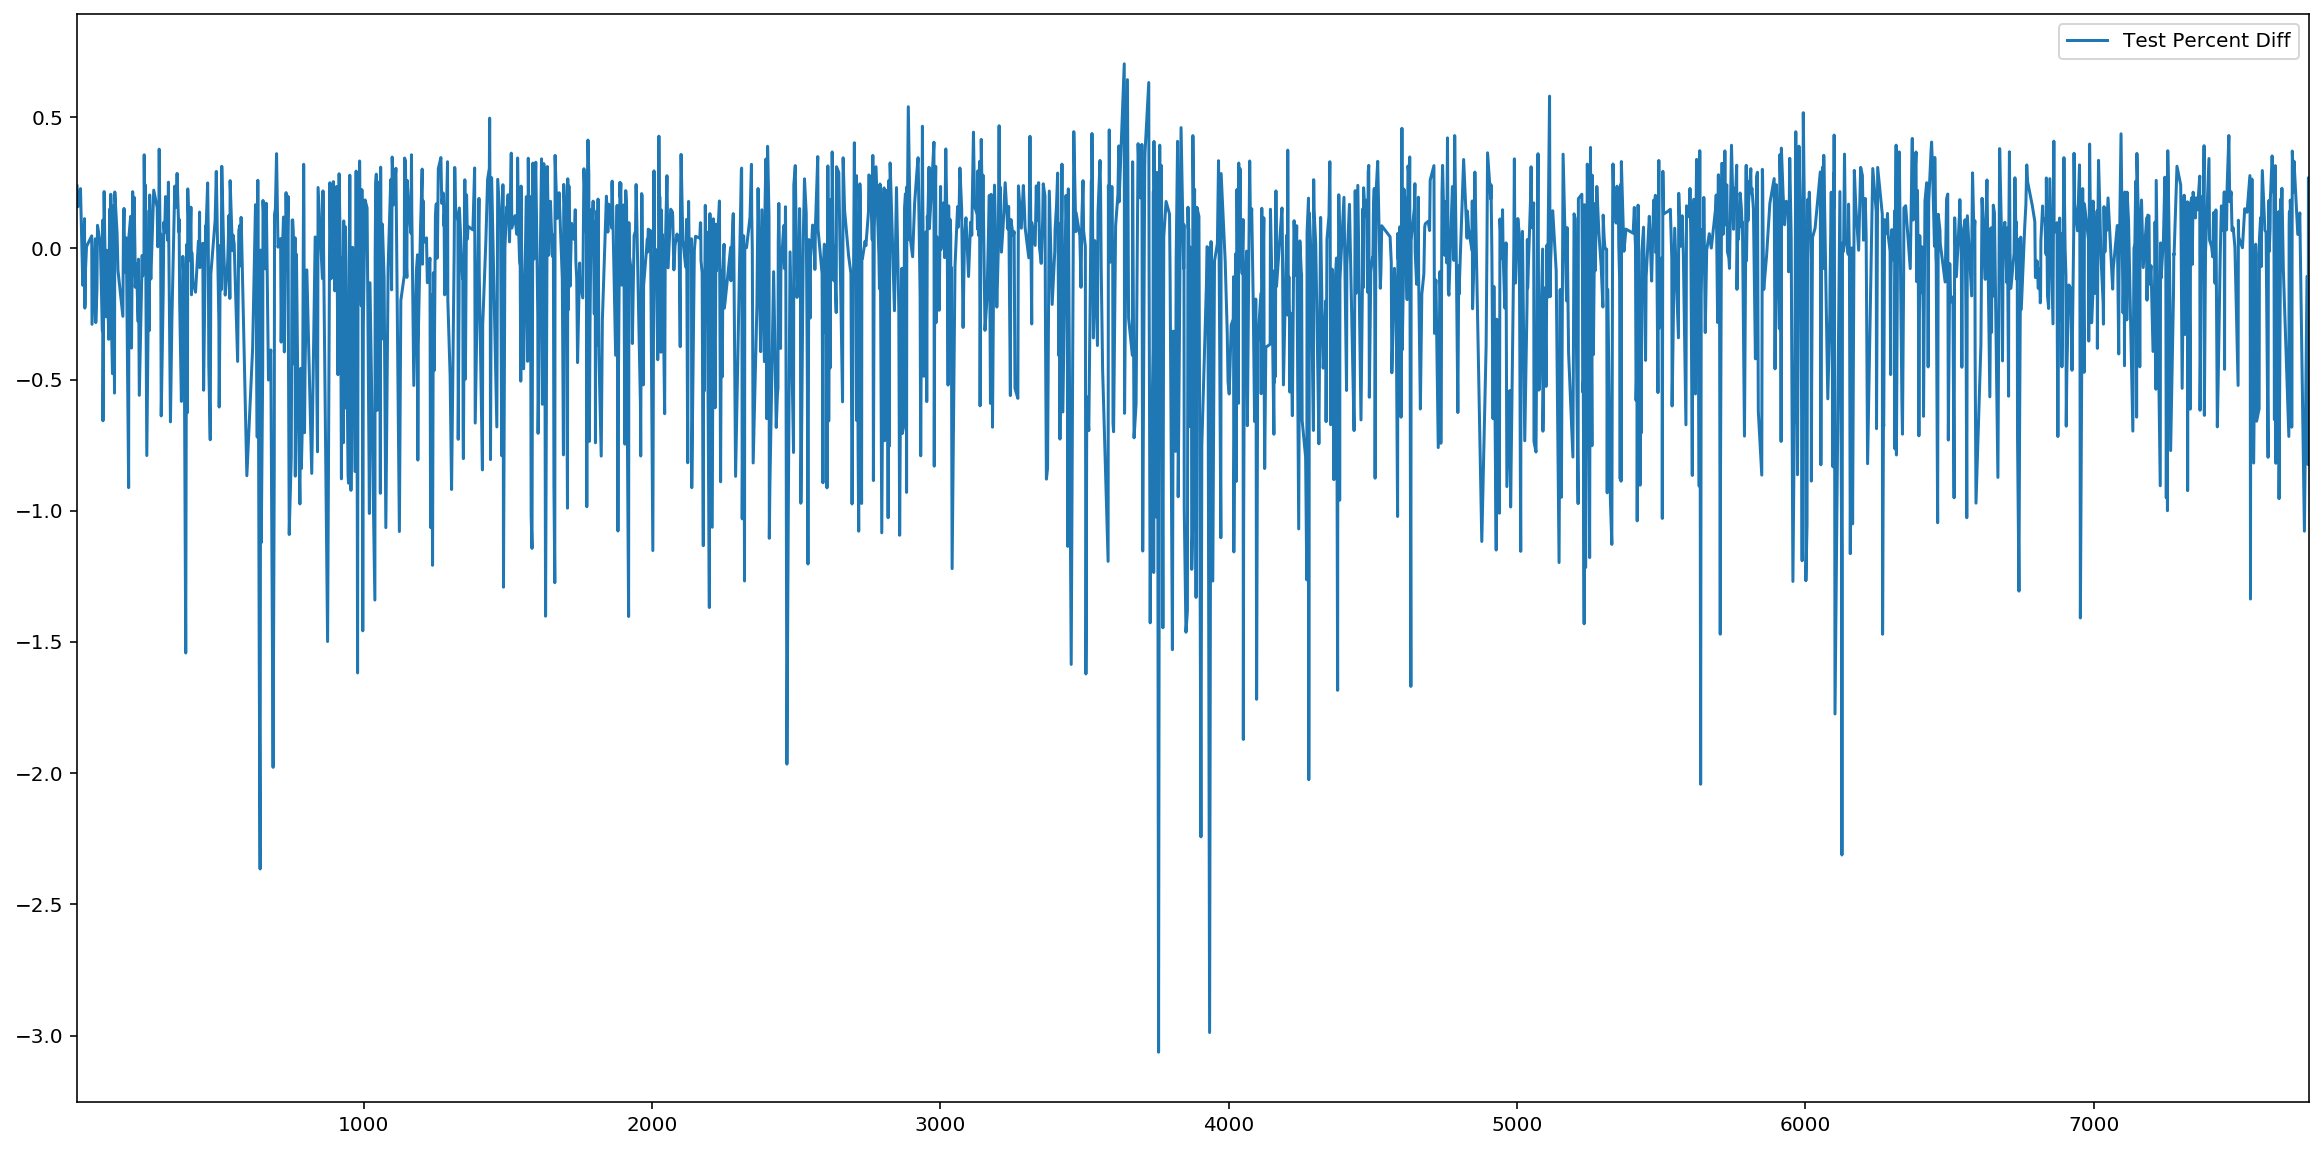

In [70]:
posts_predictions[posts_predictions['Actual Test Engagements'].notnull()].loc[:, ['Test Percent Diff']].plot(figsize=(20,10))

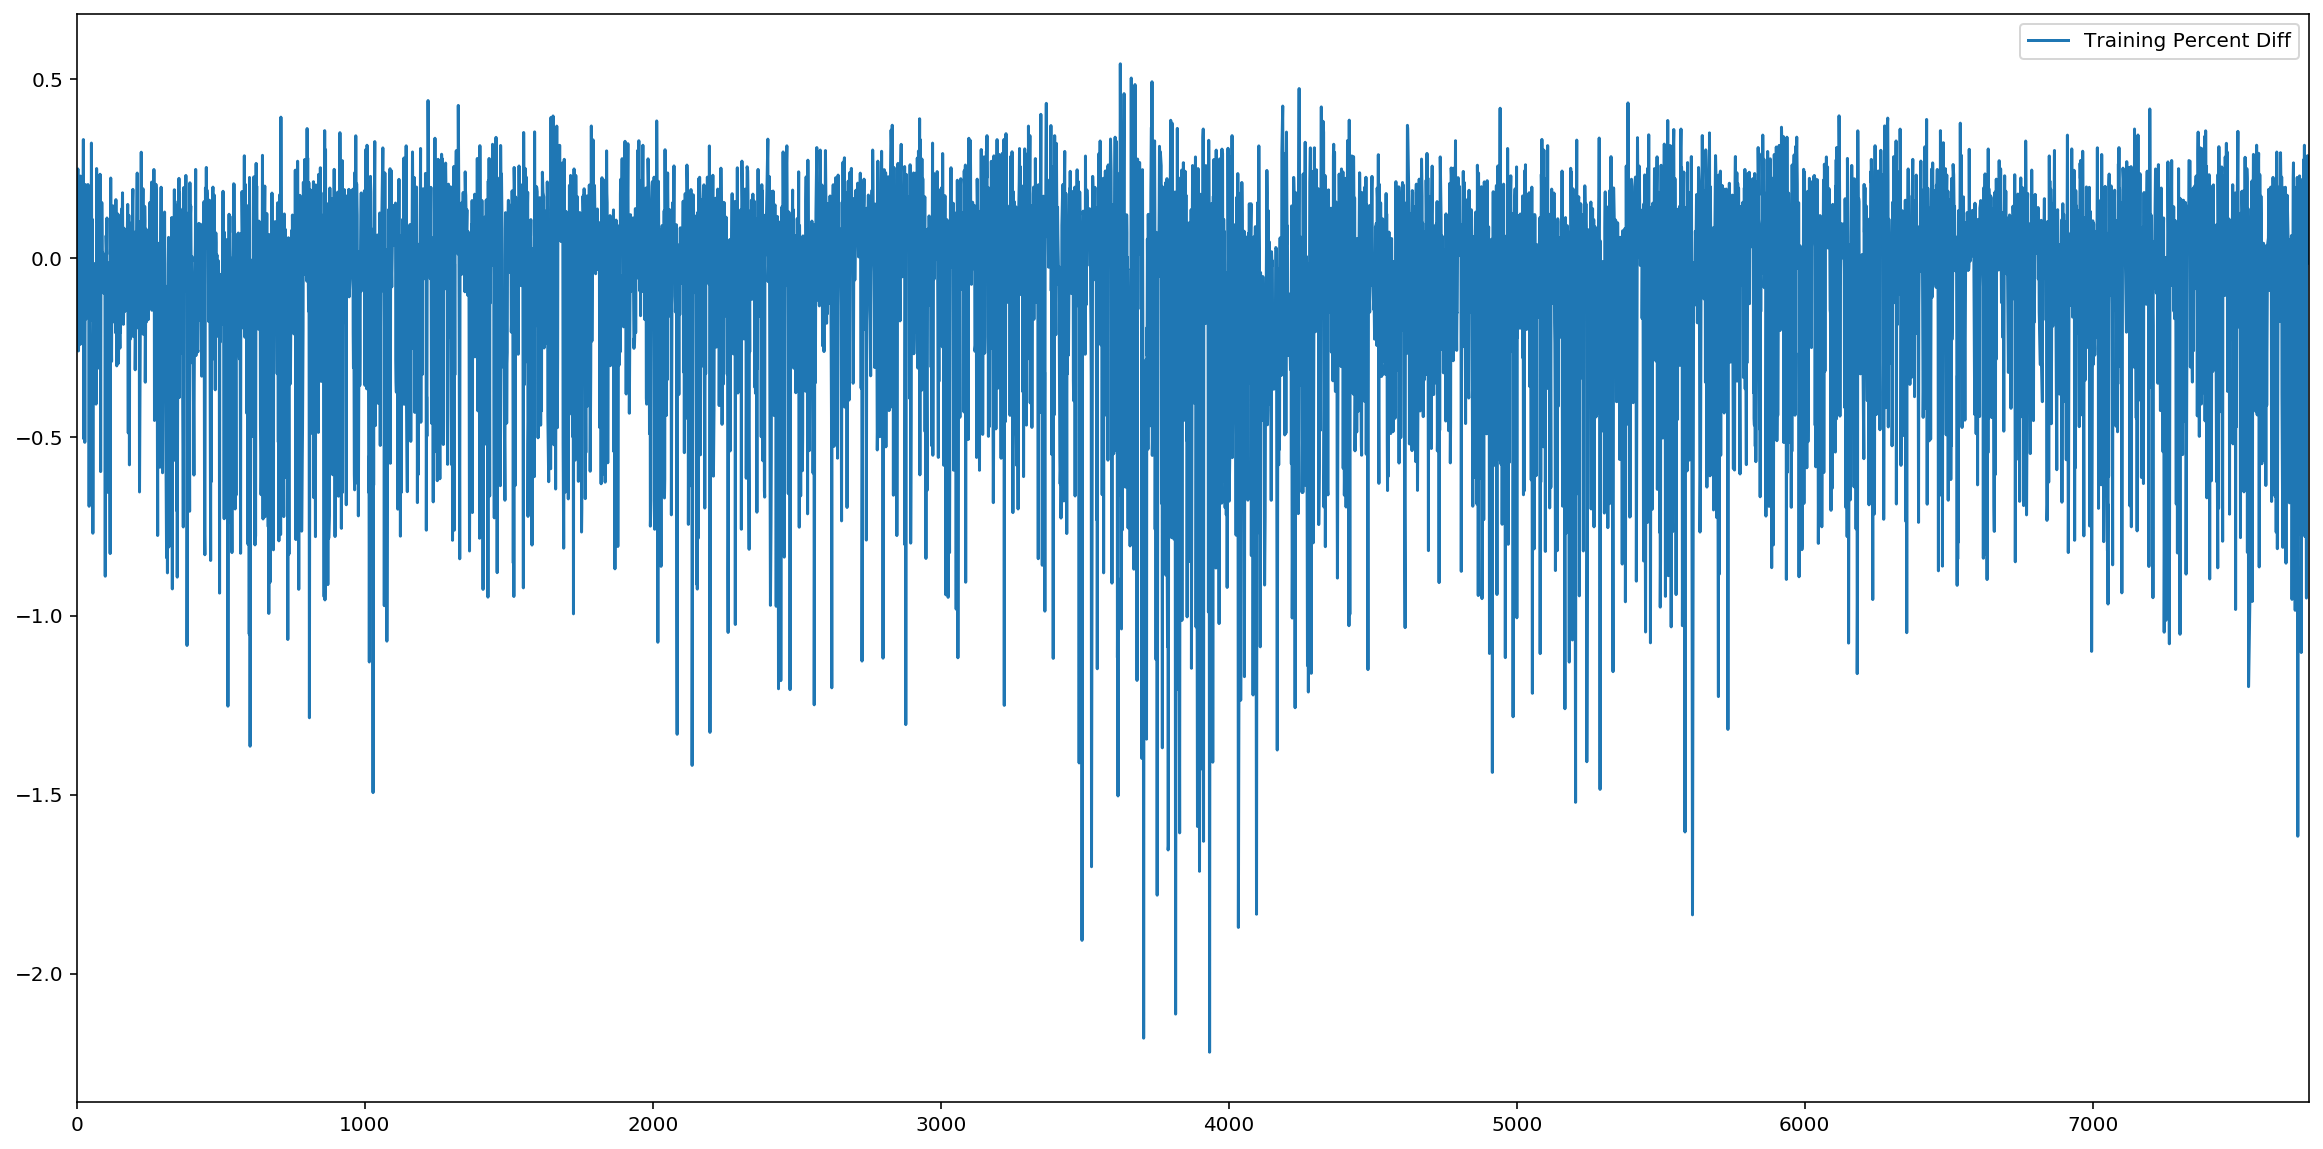

In [71]:
posts_predictions[posts_predictions['Actual Training Engagements'].notnull()].loc[:, ['Training Percent Diff']].plot(figsize=(20,10))

In [72]:
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error
mse = mean_squared_error(y_train, y_train_predictions)
mae = mean_absolute_error(y_train, y_train_predictions)
print(
  """
  Training
  -----
  Mean Squared Error: {mse}
  Mean Absolute Error: {mae}
  Root Mean Squared Error: {rmse}
  """.format(mse=mse, mae=mae, rmse=sqrt(mse))
)
test_mse = mean_squared_error(y_test, y_test_predictions)
test_mae = mean_absolute_error(y_test, y_test_predictions)
print(
  """
  Testing
  -----
  Mean Squared Error: {mse}
  Mean Absolute Error: {mae}
  Root Mean Squared Error: {rmse}
  """.format(mse=test_mse, mae=test_mae, rmse=sqrt(test_mse))
)



  Training
  -----
  Mean Squared Error: 19700391437.48202
  Mean Absolute Error: 111898.43590627154
  Root Mean Squared Error: 140358.08290754765
  

  Testing
  -----
  Mean Squared Error: 31937770115.525417
  Mean Absolute Error: 141794.10770025838
  Root Mean Squared Error: 178711.41573924542
  
